In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MSE

### Training a sequential model for MNIST dataset

In [2]:
def train_mnist() -> tf.keras.models.Model:
    """
    Train an MNIST classifier.
    
    Returns:
            Trained Keras model.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(8, 8)),
            tf.keras.layers.MaxPooling2D((4, 4)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax'),
        ]
    )
    
    print(model.summary())
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1, restore_best_weights=True)
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks)
    
    return model

In [3]:
model = train_mnist()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 21, 21, 64)        4160      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                16010     
                                                                 
Total params: 20,170
Trainable params: 20,170
Non-trainable params: 0
____________________________________________________

### Adversarial Attack

In [300]:
def generate_image_adversary(model, image, label, eps= 10.0 / 255):

    # cast the image
    image = tf.cast(image, tf.float32)

    # record our gradients
    with tf.GradientTape(persistent=True) as tape:
        # explicitly indicate that our image should be tacked for gradient updates
        tape.watch(image)

        # use our model to make predictions on the input image and then compute the loss
        pred = model(image)
        loss = MSE(label, pred)

    # calculate the gradients of loss with respect to the image, then compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)

    # construct the image adversary
    # DOUBT HERE
    # On adding the noise, we are getting prob. close to 1 and not misclassifying
    # On subtracting the noise, we are successfully able to misclassify. But we shd be adding the nosie to image, not subtracting it
    adversary = (image - (signedGrad * eps))

    # return the image adversary to the calling function
    return adversary

### Original image

1/1 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'Selected Image\n class: 8, prob: 0.9932345747947693')

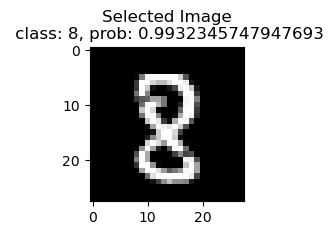

In [293]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
#x_train.shape

# # add a channel dimension to the images
# x_train = np.expand_dims(x_train, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

# one-hot encode our labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Get a random test sample
x_test_sample_ind = np.random.randint(0, x_test.shape[0])
random_sample = x_test[x_test_sample_ind, ...].reshape(1, 28, 28)

original_prediction = model.predict(random_sample)
original_prediction_class = np.argmax(original_prediction)
original_prediction_probability = np.max(original_prediction)

plt.figure(figsize=(2, 2))
plt.imshow(random_sample[0], cmap=plt.get_cmap('gray'))
plt.title(f'Selected Image\n class: {original_prediction_class}, prob: {original_prediction_probability}')

### Adversarial Image

In [301]:
# grab the current image and label
image = random_sample
label = original_prediction_probability
# image.shape

# generate an image adversary for the current image and make a prediction on the adversary
adversary = generate_image_adversary(model, image.reshape(1, 28, 28, 1), label)
pred = model.predict(adversary)
updated_prediction_class = np.argmax(pred)
updated_prediction_probability = np.max(pred)

1/1 [==============================] - 0s 37ms/step


Text(0.5, 1.0, 'Adversarial Image\n, class: 2, prob: 0.5057409405708313')

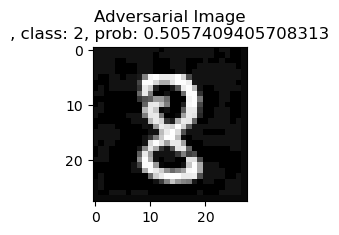

In [302]:
plt.figure(figsize=(2, 2))
plt.imshow(adversary[0], cmap=plt.get_cmap('gray'))
plt.title(f'Adversarial Image\n, class: {updated_prediction_class}, prob: {updated_prediction_probability}')

Text(0.5, 1.0, 'Adversarial Image\n, class: 2, prob: 0.5057409405708313')

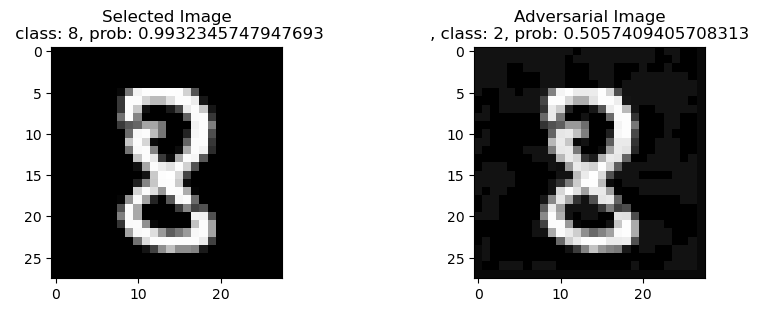

In [304]:
diff = abs(random_sample[0] - adversary[0])
# diff
# diff.shape
# random_sample.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].imshow(random_sample[0], cmap=plt.get_cmap('gray'))
axes[0].set_title(f'Selected Image\n class: {original_prediction_class}, prob: {original_prediction_probability}')

axes[1].imshow(adversary[0], cmap=plt.get_cmap('gray'))
axes[1].set_title(f'Adversarial Image\n, class: {updated_prediction_class}, prob: {updated_prediction_probability}')

# axes[2].imshow(diff[0][0], cmap=plt.get_cmap('gray'))